In [1]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf

from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

from tensorflow.keras.applications import InceptionResNetV2

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [4]:
unZip('drive/My Drive/Research/dataset_tb.zip')

Done!


In [0]:
!ls dataset

0  1


In [0]:
import glob
filesN= sorted(glob.glob('dataset/0/*.png'))
filesP= sorted(glob.glob('dataset/1/*.png'))

In [6]:
filesN,filesP

(['dataset/0/CHNCXR_0001_0.png',
  'dataset/0/CHNCXR_0002_0.png',
  'dataset/0/CHNCXR_0003_0.png',
  'dataset/0/CHNCXR_0004_0.png',
  'dataset/0/CHNCXR_0005_0.png',
  'dataset/0/CHNCXR_0006_0.png',
  'dataset/0/CHNCXR_0007_0.png',
  'dataset/0/CHNCXR_0008_0.png',
  'dataset/0/CHNCXR_0009_0.png',
  'dataset/0/CHNCXR_0010_0.png',
  'dataset/0/CHNCXR_0011_0.png',
  'dataset/0/CHNCXR_0012_0.png',
  'dataset/0/CHNCXR_0013_0.png',
  'dataset/0/CHNCXR_0014_0.png',
  'dataset/0/CHNCXR_0015_0.png',
  'dataset/0/CHNCXR_0016_0.png',
  'dataset/0/CHNCXR_0017_0.png',
  'dataset/0/CHNCXR_0018_0.png',
  'dataset/0/CHNCXR_0019_0.png',
  'dataset/0/CHNCXR_0020_0.png',
  'dataset/0/CHNCXR_0021_0.png',
  'dataset/0/CHNCXR_0022_0.png',
  'dataset/0/CHNCXR_0023_0.png',
  'dataset/0/CHNCXR_0024_0.png',
  'dataset/0/CHNCXR_0025_0.png',
  'dataset/0/CHNCXR_0026_0.png',
  'dataset/0/CHNCXR_0027_0.png',
  'dataset/0/CHNCXR_0028_0.png',
  'dataset/0/CHNCXR_0029_0.png',
  'dataset/0/CHNCXR_0030_0.png',
  'dataset

In [0]:
pos_labels=[[i,1] for i in filesP]
neg_labels=[[i,0] for i in filesN]
ds=pos_labels+neg_labels

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.1, random_state=42)

In [0]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

In [0]:

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dfTrain['path'], dfTrain['label']))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(16)
    .prefetch(AUTO)
)


In [0]:
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dfTest['path'], dfTest['label']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(16)
    .cache()
    .prefetch(AUTO)
)

In [0]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    # lr_max = lr_max * strategy.num_replicas_in_sync

    # def lrfn(epoch):
    #     if epoch < lr_rampup_epochs:
    #         lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    #     elif epoch < lr_rampup_epochs + lr_sustain_epochs:
    #         lr = lr_max
    #     else:
    #         lr = (lr_max - lr_min) *\
    #              lr_exp_decay**(epoch - lr_rampup_epochs\
    #                             - lr_sustain_epochs) + lr_min
        # return 0.00001
    return 0.00001

In [0]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = dfTrain['path'].shape[0] // 16
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [17]:
model4 = tf.keras.Sequential([InceptionResNetV2(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(1,
                                         activation='softmax')])
        
model4.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
model4.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 14, 14, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


In [20]:
history = model4.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/50
37/37 [==============================] - 77s 2s/step - loss: 7.3413 - accuracy: 0.5186 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 2/50
37/37 [==============================] - 76s 2s/step - loss: 7.4701 - accuracy: 0.5101 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 3/50
37/37 [==============================] - 78s 2s/step - loss: 7.5216 - accuracy: 0.5068 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 4/50
37/37 [==============================] - 74s 2s/step - loss: 7.3928 - accuracy: 0.5152 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 5/50
37/37 [==============================] - 77s 2s/step - loss: 7.0837 - accuracy: 0.5355 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 6/50
37/37 [==============================] - 75s 2s/step - loss: 7.5216 - accuracy: 0.5068 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 7/50
37/37 [==============================] - 75s 2s/step - loss: 7.3670 - accuracy: 0.5169 - val_loss: 8.5142 - val_accuracy: 0.4627
Epoch 8/50
37/37 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


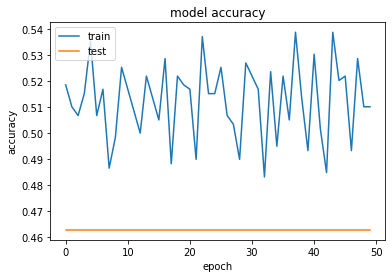

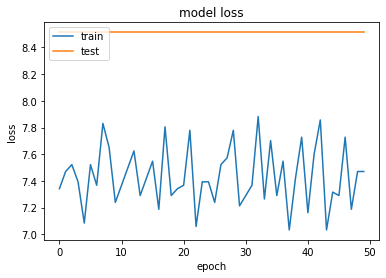

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()